### SOM

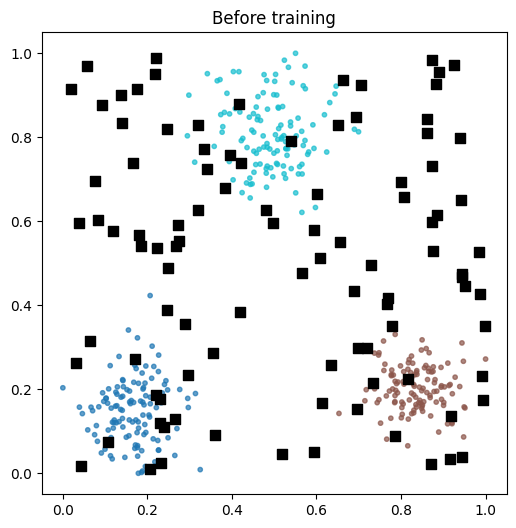

Epoch 1/150: lr=0.7000, radius=5.0000
Epoch 32/150: lr=0.5693, radius=3.5852
Epoch 63/150: lr=0.4630, radius=2.5708
Epoch 94/150: lr=0.3766, radius=1.8434
Epoch 125/150: lr=0.3063, radius=1.3218


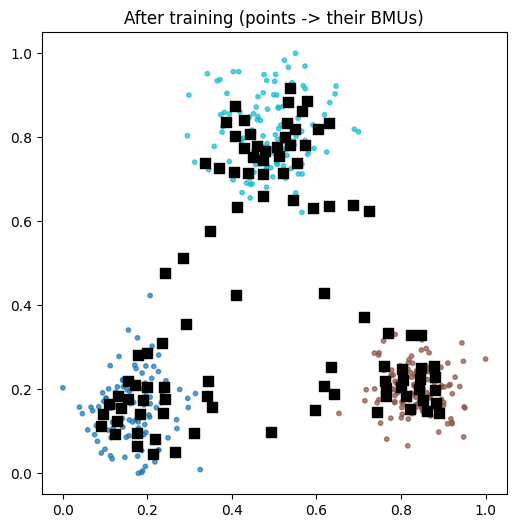

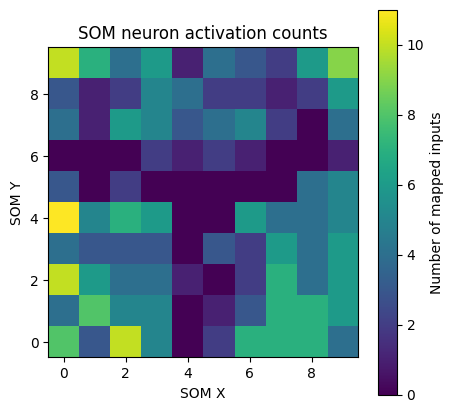

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class SOM:
    def __init__(self, m, n, dim, learning_rate=0.5, radius=None, epochs=100):
        self.m = m; self.n = n; self.dim = dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = np.random.rand(m, n, dim)
        self.initial_radius = radius if radius is not None else max(m, n) / 2.0
        self.time_constant = epochs / np.log(self.initial_radius + 1e-9)
        self._neuron_locations = np.array([[i, j] for i in range(m) for j in range(n)]).reshape(m, n, 2)

    def _find_bmu(self, x):
        diffs = self.weights - x
        distances = np.linalg.norm(diffs, axis=2)
        bmu_idx = np.unravel_index(np.argmin(distances), (self.m, self.n))
        return bmu_idx

    def _neighborhood_function(self, bmu, radius):
        dist_sq = np.sum((self._neuron_locations - np.array(bmu))**2, axis=2)
        h = np.exp(-dist_sq / (2 * (radius**2 + 1e-9)))
        return h

    def train(self, data, verbose=False):
        num_samples = data.shape[0]
        for epoch in range(self.epochs):
            lr = self.learning_rate * np.exp(-epoch / self.epochs)
            radius = self.initial_radius * np.exp(-epoch / self.time_constant)
            idxs = np.random.permutation(num_samples)
            for idx in idxs:
                x = data[idx]
                bmu = self._find_bmu(x)
                h = self._neighborhood_function(bmu, radius)  # (m, n)
                influence = h[:, :, np.newaxis]
                self.weights += lr * influence * (x - self.weights)
            if verbose and (epoch % (self.epochs // 5 + 1) == 0):
                print(f"Epoch {epoch+1}/{self.epochs}: lr={lr:.4f}, radius={radius:.4f}")

    def map_vects(self, data):
        bmu_coords = np.zeros((data.shape[0], 2), dtype=int)
        for i, x in enumerate(data):
            bmu_coords[i] = self._find_bmu(x)
        return bmu_coords

# Example: create 3 clusters in 2D and run the SOM
np.random.seed(42)
n_per_cluster = 120
centers = np.array([[0.2, 0.2], [0.8, 0.25], [0.5, 0.75]])
stds = [0.06, 0.05, 0.07]
points = []
labels = []
for i, (c, s) in enumerate(zip(centers, stds)):
    pts = np.random.normal(loc=c, scale=s, size=(n_per_cluster, 2))
    points.append(pts); labels.extend([i] * n_per_cluster)
data = np.vstack(points); labels = np.array(labels)

# Normalize
data_min, data_max = data.min(axis=0), data.max(axis=0)
data_norm = (data - data_min) / (data_max - data_min + 1e-9)

som = SOM(m=10, n=10, dim=2, learning_rate=0.7, epochs=150)

# Plot before training
plt.figure(figsize=(6,6))
plt.scatter(data_norm[:,0], data_norm[:,1], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.scatter(som.weights[:,:,0].ravel(), som.weights[:,:,1].ravel(), marker='s', s=50, c='black')
plt.title("Before training")
plt.show()

# Train & plot after
som.train(data_norm, verbose=True)
plt.figure(figsize=(6,6))
plt.scatter(data_norm[:,0], data_norm[:,1], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.scatter(som.weights[:,:,0].ravel(), som.weights[:,:,1].ravel(), marker='s', s=50, c='black')
bmus = som.map_vects(data_norm)
for i, (x,y) in enumerate(data_norm):
    bx, by = bmus[i]; nx = som.weights[bx,by,0]; ny = som.weights[bx,by,1]
    plt.plot([x,nx],[y,ny], color=plt.cm.tab10(labels[i]), alpha=0.03, linewidth=0.6)
plt.title("After training (points -> their BMUs)")
plt.show()

# Heatmap of BMU counts
counts = np.zeros((som.m, som.n), dtype=int)
for (bx, by) in bmus: counts[bx,by] += 1
plt.figure(figsize=(5,5))
plt.imshow(counts.T, origin='lower', cmap='viridis')
plt.colorbar(label='Number of mapped inputs')
plt.title('SOM neuron activation counts')
plt.xlabel('SOM X'); plt.ylabel('SOM Y')
plt.show()


In [2]:
import math

# Initial weights
w1 = [1.0, 2.0]
w2 = [10.0, 10.0]

alpha = 0.4  # learning rate
inputs = [(2.0, 3.0), (3.0, 4.0), (8.0, 7.0), (9.0, 8.0)]

# Function to compute Euclidean distance
def dist(p, w):
    return math.sqrt((p[0] - w[0])**2 + (p[1] - w[1])**2)

print("Initial Weights:")
print("N1:", w1)
print("N2:", w2)

# Cluster assignment tracking
cluster = []

for p in inputs:
    d1 = dist(p, w1)
    d2 = dist(p, w2)

    if d1 < d2:
        winner = "N1"
        # Update w1
        w1[0] = w1[0] + alpha * (p[0] - w1[0])
        w1[1] = w1[1] + alpha * (p[1] - w1[1])
    else:
        winner = "N2"
        # Update w2
        w2[0] = w2[0] + alpha * (p[0] - w2[0])
        w2[1] = w2[1] + alpha * (p[1] - w2[1])

    cluster.append((p, winner))

print("\nFinal Weights after One Epoch:")
print("N1:", w1)
print("N2:", w2)

print("\nCluster Assignment:")
for p, win in cluster:
    print(f"Input {p} → {win}")


Initial Weights:
N1: [1.0, 2.0]
N2: [10.0, 10.0]

Final Weights after One Epoch:
N1: [2.04, 3.04]
N2: [9.12, 8.48]

Cluster Assignment:
Input (2.0, 3.0) → N1
Input (3.0, 4.0) → N1
Input (8.0, 7.0) → N2
Input (9.0, 8.0) → N2
